In [1]:
%reset
import numpy as np
import skimage.transform as tf
import pickle
from matplotlib import pyplot as plt
import math

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def import_data():
    x = np.load('./data/x_minus_one_scaled_hist_eq_zero_mean_zca_aligned_minus_one.npy','r')
        
    with open('./data/y_resized_raster.pickle','rb') as f:
        y = pickle.load(f)
        y = y.astype(np.float32)
        
    return x, y

In [21]:
def rotater(x,y):
    i = np.random.choice(range(25))
    angle = np.random.uniform(30,330)
    img_x = x[i,...].copy()
    img_y = y[i,...].copy()
    for channel in range(x.shape[1]):
        img_x[channel,...] = tf.rotate(img_x[channel,...],
                          angle=angle,
                          order=0,
                          mode='reflect')
    for classID in range(y.shape[1]):
        img_y[classID,...] = tf.rotate(img_y[classID,...],
                          angle=angle,
                          order=0,
                          mode='reflect')
    return img_x[np.newaxis,...], img_y[np.newaxis,...]

In [80]:
x, y = import_data()

In [81]:
for i in range(375):
    x_rot,y_rot = rotater(x,y)
    if np.random.uniform()>0.25: # Flip LR
        x_rot = x_rot[:,:,:,::-1]
        y_rot = y_rot[:,:,:,::-1]
    if np.random.uniform()>0.25: # Flip LR
        x_rot = x_rot[:,:,::-1,:]
        y_rot = y_rot[:,:,::-1,:]
    x = np.append(x,x_rot,axis=0)
    y = np.append(y,y_rot,axis=0)
print(x.shape,y.shape)

(400, 20, 136, 136) (400, 10, 136, 136)


In [82]:
from sklearn.utils import shuffle
x,y = shuffle(x,y,random_state=13)

In [83]:
y[y>0]=1

In [84]:
np.save('./data/x_augmented.npy',x)
np.save('./data/y_augmented.npy',y)

52


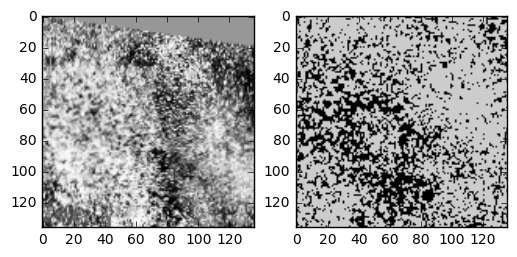

In [60]:
def plot_all(c):
    fig = plt.figure(figsize=(6,6))
    i = np.random.choice(400)
    print(i)
    ax1 = fig.add_subplot(221)
    ax1.imshow(np.rollaxis(x[319,...],0,3)[:,:,1],cmap='Greys')

    ax2 = fig.add_subplot(222)
    ax2.imshow(y[319,c,...],cmap='spectral')
    
    plt.show()
plot_all(5)
#push('PICTURES!','The plots are ready')

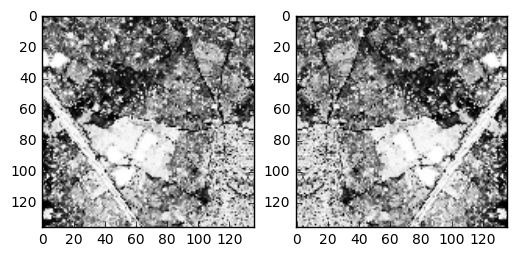

In [65]:
def plot_all(c):
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(221)
    ax1.imshow(x[0,0,:,::-1],cmap='Greys')

    ax2 = fig.add_subplot(222)
    ax2.imshow(x[0,0,:,:],cmap='Greys')
    
    plt.show()
plot_all(5)
#push('PICTURES!','The plots are ready')

In [37]:
def plot_all(i,classType):
    fig = plt.figure(figsize=(6,6))

    ax1 = fig.add_subplot(121)
    ax1.imshow(x[i,1,...],cmap='Greys')

    ax2 = fig.add_subplot(122)
    ax2.imshow(y[i,classType,...].astype(np.float32),cmap='spectral')
    
    plt.show()
#plot_all(2,2,classType,0.5)
#push('PICTURES!','The plots are ready')

50


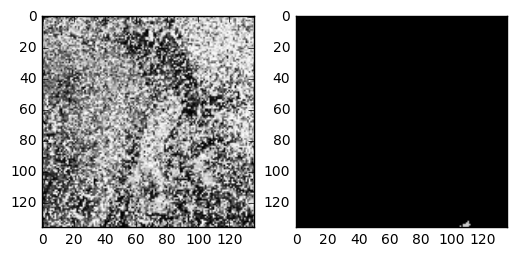

In [43]:
i = np.random.choice(range(50,75),1)[0]
print(i)
plot_all(i,3)